In [1]:
import importlib, inspect
import mintpy.cli.tsview as tsview_cli
import mintpy.tsview as tsview_core

print("CLI:", tsview_cli.__file__)
print("CORE:", tsview_core.__file__)
      

CLI: /opt/conda/lib/python3.10/site-packages/mintpy/cli/tsview.py
CORE: /opt/conda/lib/python3.10/site-packages/mintpy/tsview.py


In [2]:
import inspect, mintpy.cli.tsview as tsview_cli
print(inspect.getsource(tsview_cli))


#!/usr/bin/env python3
############################################################
# Program is part of MintPy                                #
# Copyright (c) 2013, Zhang Yunjun, Heresh Fattahi         #
# Author: Antonio Valentino, Zhang Yunjun, Aug 2022        #
############################################################


import os
import sys

from mintpy.utils import arg_utils

###########################################################################################
EXAMPLE = """example:
  tsview.py timeseries.h5
  tsview.py timeseries.h5  --wrap
  tsview.py timeseries.h5  --yx 300 400 --zero-first  --nodisplay
  tsview.py geo_timeseries.h5  --lalo 33.250 131.665  --nodisplay
  tsview.py slcStack.h5 -u dB -v 20 60 -c gray

  # press left / right key to slide images

  # multiple time-series files
  tsview.py timeseries_ERA5_ramp_demErr.h5 timeseries_ERA5_ramp.h5 timeseries_ERA5.h5 timeseries.h5 --off 5
  tsview.py timeseries_ERA5_ramp_demErr.h5 ../GIANT/Stack/LS-PARAMS.h5 --of

In [3]:
import mintpy.tsview as tsview_core
print(inspect.getsource(tsview_core))

#############################################################
# Program is part of MintPy                                 #
# Copyright (c) 2013, Zhang Yunjun, Heresh Fattahi          #
# Author: Zhang Yunjun, Joshua Zahner, Heresh Fattahi, 2013 #
#############################################################


import argparse
import os
import re

import numpy as np
from matplotlib import patches, pyplot as plt, widgets
from scipy import linalg, stats

from mintpy import subset, timeseries2velocity as ts2vel, view
from mintpy.multilook import multilook_data
from mintpy.objects import HDFEOS, giantTimeseries, timeseries
from mintpy.utils import plot as pp, ptime, readfile, time_func, utils as ut


###########################################################################################
def read_init_info(inps):
    """Read and initialize metadata and parameters.

    Parameters
    ----------
    inps : Namespace
        Input arguments from the command line parser.

    Returns
    --

In [4]:
import h5py

ts_file = '/mnt/data_storage/Jakarta_small/run/mintpy/geo/geo_timeseries_ramp_demErr.h5'

with h5py.File(ts_file, 'r') as f :
    print("Root keys:", list(f.keys()))
    print("timeseries shepe:", f["/timeseries"].shape)
    print("date shape:", f["/date"].shape)
    print("attrs:", dict(f.attrs))

Root keys: ['bperp', 'date', 'timeseries']
timeseries shepe: (189, 382, 1378)
date shape: (189,)
attrs: {'ALOOKS': '5', 'ANTENNA_SIDE': '-1', 'AZIMUTH_PIXEL_SIZE': '78.06701677960027', 'BANDS': '2', 'CENTER_INCIDENCE_ANGLE': '41.5995', 'CENTER_LINE_UTC': '40520.0', 'DATA_TYPE': 'float32', 'DATE12': '160123-160216', 'EARTH_RADIUS': '6338239.669333842', 'END_DATE': '20221229', 'FILE_LENGTH': '568', 'FILE_PATH': '/mnt/data_storage/Jakarta_small/run/mintpy/timeseries_ramp_demErr.h5', 'FILE_TYPE': 'timeseries', 'HEADING': '-12.065208197820438', 'HEIGHT': '700148.3178983292', 'INTERLEAVE': 'BIL', 'LAT_REF1': '-6.3209040953033355', 'LAT_REF2': '-6.3080962444862445', 'LAT_REF3': '-6.219894186556803', 'LAT_REF4': '-6.207834202637028', 'LENGTH': '382', 'LON_REF1': '106.574763601587', 'LON_REF2': '106.63229502640134', 'LON_REF3': '107.00611213375497', 'LON_REF4': '107.060070188318', 'NCORRLOOKS': '38.76551755689972', 'NO_DATA_VALUE': 'none', 'OG_FILE_PATH': '/mnt/data_storage/Jakarta_small/run/me

In [9]:
import h5py, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# 入力
ts_file = "/mnt/data_storage/Jakarta_small/run/mintpy/geo/geo_timeseries_ramp_demErr.h5"
out_png  = "timeseries_frame_2nd_ref1st.png"   # 出力ファイル名
vlim_mm  = (-10, 10)                           # 色範囲（mm）必要に応じて調整

with h5py.File(ts_file, "r") as f:
    # 3D: (T, H, W)
    ts = f["/timeseries"][...].astype(np.float32)      # 単位：m（MintPy標準）
    dates = [d.decode() if isinstance(d, bytes) else str(d) for d in f["/date"][...]]
    atr = {k: (v.decode() if isinstance(v, bytes) else v) for k, v in f.attrs.items()}

# 1枚目を基準にして2枚目の累積（= 2枚目 − 1枚目）
img_mm = ts[57] * 1000.0                       # mm へ変換

# NaN マスク（全部0や未観測の場所がある場合に備え）
img = np.array(img_mm)
img[~np.isfinite(img)] = np.nan

# 地理範囲（imshowのextent用）
x_first = float(atr["X_FIRST"]);  x_step = float(atr["X_STEP"])
y_first = float(atr["Y_FIRST"]);  y_step = float(atr["Y_STEP"])
length  = int(atr["LENGTH"]);     width  = int(atr["WIDTH"])

lons = x_first + np.arange(width) * x_step
lats = y_first + np.arange(length) * y_step
extent = [lons.min(), lons.max(), lats.min(), lats.max()]  # [xmin, xmax, ymin, ymax]

# 描画
fig = plt.figure(figsize=(9, 3), dpi=140)
ax  = plt.axes()
im  = ax.imshow(img, extent=extent, origin="upper",
                vmin=vlim_mm[0], vmax=vlim_mm[1], cmap="RdYlBu_r", interpolation="nearest")
cb  = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02); cb.set_label("mm")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

# タイトル（2枚目の日付を表示）
ax.set_title(f"Cumulative LOS displacement (mm)\nDate: {dates[1]}  (ref: {dates[0]})")
plt.tight_layout()
fig.savefig(out_png)
plt.close(fig)

print(f"Saved: {out_png}  | date2={dates[1]} ref={dates[0]}  | vlim={vlim_mm}")


Saved: timeseries_frame_2nd_ref1st.png  | date2=20160216 ref=20160123  | vlim=(-10, 10)


In [10]:
img.shape

(382, 1378)

In [11]:
img


array([[         nan,          nan,          nan, ...,  197.69522  ,
          47.264175 ,  -40.598175 ],
       [         nan,          nan,          nan, ...,   79.05839  ,
        -185.01187  ,  158.75945  ],
       [         nan,          nan,          nan, ..., -114.10846  ,
         -35.03494  ,   44.77197  ],
       ...,
       [  17.758772 ,   21.35131  ,    6.3819876, ...,          nan,
                 nan,          nan],
       [  13.645019 ,   30.696436 ,   87.15881  , ...,          nan,
                 nan,          nan],
       [ 104.50683  ,    0.       ,    0.       , ...,          nan,
                 nan,          nan]], dtype=float32)

In [12]:
import h5py, numpy as np
f = h5py.File(ts_file,"r")
ts = f["/timeseries"]; dates = f["/date"].asstr()[...]
for i, d in enumerate(dates[:10]):  # 最初の10枚だけ
    img = ts[i, ...]
    valid = np.isfinite(img).sum()
    print(d, "valid:", valid, "/", img.size)
f.close()

20160123 valid: 23165 / 526396
20160216 valid: 23165 / 526396
20160311 valid: 23165 / 526396
20160404 valid: 23165 / 526396
20160428 valid: 23165 / 526396
20160522 valid: 23165 / 526396
20160615 valid: 23165 / 526396
20160709 valid: 23165 / 526396
20160802 valid: 23165 / 526396
20160826 valid: 23165 / 526396


In [13]:
import h5py, numpy as np

p = "/mnt/data_storage/Jakarta_small/run/mintpy/inputs/geometryRadar.h5"
with h5py.File(p, "r") as f:
    lat = f["/latitude"][:]
    lon = f["/longitude"][:]
print("lat min/max:", float(np.nanmin(lat)), float(np.nanmax(lat)))
print("lon min/max:", float(np.nanmin(lon)), float(np.nanmax(lon)))

lat min/max: -6.346985340118408 -6.156952857971191
lon min/max: 106.45675659179688 107.28895568847656


plot_ts.py /mnt/data_storage/Jakarta_small/run/mintpy/timeseries.h5 --idx 42 --no-slider
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 1699, 568)
subset coverage in y/x: (0, 0, 1699, 568)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
total number of pixels: 1.8E+08
* multilook 3 by 3 with nearest interpolation for display to save memory
reference point in y/x: (86, 990)
ASCENDING orbit -> flip up-down
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file /mnt/data_storage/Jakarta_small/run/mintpy/timeseries.h5 with step of 3 by 3
reading 2D slices 189/189...
reference to date: 20220831
read mask from file: maskTempCoh.h5
data    range: [-41.378242, 83.6187

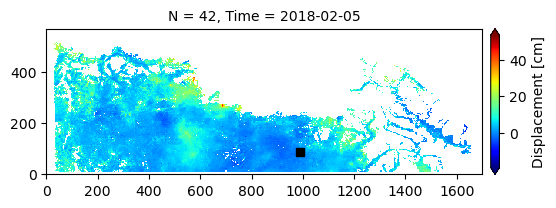

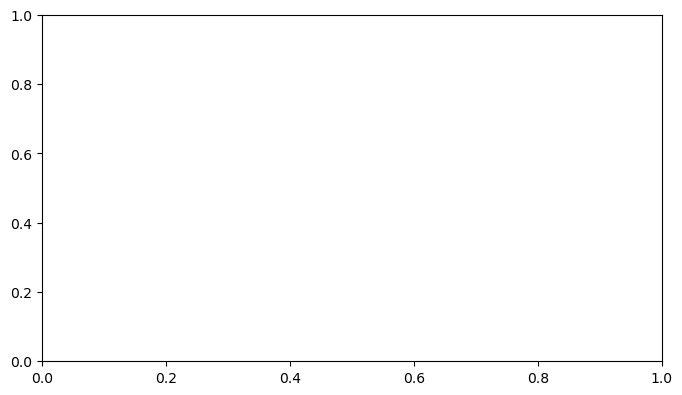

In [3]:
import os, sys, importlib
os.chdir('/work')
sys.path.append('/work')  # 念のため

# ツールをリロード（コード更新を反映）
if 'tools.tsview_cli' in sys.modules:
    importlib.reload(sys.modules['tools.tsview_cli'])
else:
    import tools.tsview_cli

if 'tools.plot_ts' in sys.modules:
    importlib.reload(sys.modules['tools.plot_ts'])
else:
    import tools.plot_ts

from tools.tsview_cli import cmd_line_parse
from tools.plot_ts import timeseriesViewer

args = [
    "/mnt/data_storage/Jakarta_small/run/mintpy/timeseries.h5",
    "--idx","42",
    "--no-slider",
    # "--save",                # 保存したい場合は付ける
    # "--yx","172","540",      # 固定ピクセルのTSも同時に描画したい場合
]
inps = cmd_line_parse(args)
viewer = timeseriesViewer(inps)
viewer.open()
viewer.plot()


In [8]:
args = [
    "mintpy/timeseries.h5",
    "--idx", "42",
    "--no-slider",
    "--save",           # 保存したい場合
    #"--yx", "172", "540",   # クリックせずにこの画素のTSも出す時
]
inps = cmd_line_parse(args)
viewer = timeseriesViewer(inps)
viewer.open()
viewer.plot()

usage: ipykernel_launcher.py [-h] [--label [FILE_LABEL ...]]
                             [--ylim YMIN YMAX] [--tick-right]
                             [-l LOOKUP_FILE] [--no-show-img] [-n NUM]
                             [--error ERROR_FILE] [--start-date START_DATE]
                             [--end-date END_DATE]
                             [--exclude [EX_DATE_LIST ...]] [--zf]
                             [--off OFFSET] [--noverbose] [--nomodel]
                             [--plot-model-conf-int] [--poly POLYNOMIAL]
                             [--periodic PERIODIC [PERIODIC ...]]
                             [--step STEPDATE [STEPDATE ...]]
                             [--polyline POLYLINE [POLYLINE ...]]
                             [--exp EXP [EXP ...]] [--log LOG [LOG ...]]
                             [--yx Y X] [--lalo LAT LON] [--marker MARKER]
                             [--ms MARKER_SIZE] [--lw LINEWIDTH]
                             [--ew EDGE_WIDTH] [-v VMIN VMAX]

SystemExit: 2

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
import inspect
import mintpy.cli.tsview as tsview
print(inspect.getsource(tsview))

#!/usr/bin/env python3
############################################################
# Program is part of MintPy                                #
# Copyright (c) 2013, Zhang Yunjun, Heresh Fattahi         #
# Author: Antonio Valentino, Zhang Yunjun, Aug 2022        #
############################################################


import os
import sys

from mintpy.utils import arg_utils

###########################################################################################
EXAMPLE = """example:
  tsview.py timeseries.h5
  tsview.py timeseries.h5  --wrap
  tsview.py timeseries.h5  --yx 300 400 --zero-first  --nodisplay
  tsview.py geo_timeseries.h5  --lalo 33.250 131.665  --nodisplay
  tsview.py slcStack.h5 -u dB -v 20 60 -c gray

  # press left / right key to slide images

  # multiple time-series files
  tsview.py timeseries_ERA5_ramp_demErr.h5 timeseries_ERA5_ramp.h5 timeseries_ERA5.h5 timeseries.h5 --off 5
  tsview.py timeseries_ERA5_ramp_demErr.h5 ../GIANT/Stack/LS-PARAMS.h5 --of

In [3]:
# === 累計変位マップをGIFにする（参照日は最初の取得日） ===
import os, shutil, tempfile
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from mintpy.objects import timeseries as TsObj
from mintpy.utils import readfile, plot as pp, utils as ut, ptime

# 入力
ts_file   = "/mnt/data_storage/Jakarta_small/run/mintpy/timeseries.h5"
mask_file = None
wrap       = False
wrap_range = (-np.pi, np.pi)
cmap_name  = "RdBu_r"
out_gif    = "/work/out_cumdisp_s1.gif"
fps        = 5

# 1) データ読み込み
obj = TsObj(ts_file); obj.open(print_msg=False)
date_list = obj.dateList[:]                       # ['YYYYMMDD', ...]
dates, _  = ptime.date_list2vector(date_list)     # datetime配列
atr = readfile.read_attribute(ts_file)

# 2) 3Dスタック読み込み（全日）
data, _ = readfile.read(ts_file, datasetName=date_list)

# 3) 参照日＝最初の取得日（zero-first 相当）
data = data - data[0, :, :]

# 4) マスク
mask = pp.read_mask(ts_file, mask_file=mask_file, datasetName='displacement', print_msg=False)[0]
if mask is None:
    mask = np.ones(data.shape[-2:], np.bool_)
stack = np.nansum(data, axis=0)
mask[np.isnan(stack)] = False
del stack

# 5) 単位変換と表示範囲（全フレーム固定）
data, disp_unit, _ = pp.scale_data2disp_unit(data, metadata=atr, disp_unit='cm')
#vlim = pp.auto_adjust_colormap_lut_and_disp_limit(data, num_multilook=10, print_msg=False)[1]
vlim = (-30.0, 30.0)
cbar_label = ('Amplitude' if atr.get('DATA_TYPE','').startswith('complex') else 'Displacement') + f' [{disp_unit}]'

# 6) フレーム生成 → GIF
tmpdir = tempfile.mkdtemp(prefix="mintpy_gif_")
frames = []
try:
    ref_str = dates[0].strftime("%Y-%m-%d")
    for i in enumerate(date_list):
        i = i[0]
        img = np.array(data[i])
        img[mask == 0] = np.nan
        if wrap:
            img = ut.wrap(img, wrap_range=wrap_range)

        fig, ax = plt.subplots(figsize=(6, 4))
        im = ax.imshow(img, cmap=cmap_name, vmin=vlim[0], vmax=vlim[1])
        ax.set_axis_off()

        disp_date = dates[i].strftime("%Y-%m-%d")
        ax.set_title(f"N = {i}   Time = {disp_date}   (ref = {ref_str})", fontsize=10)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(cbar_label, fontsize=9)

        fpng = os.path.join(tmpdir, f"frame_{i:04d}.png")
        fig.tight_layout()
        fig.savefig(fpng, dpi=120)
        plt.close(fig)
        frames.append(imageio.imread(fpng))

    imageio.mimsave(out_gif, frames, duration=1.0/fps)
    print(f"✅ GIFを書き出しました: {out_gif}")
finally:
    shutil.rmtree(tmpdir, ignore_errors=True)


✅ GIFを書き出しました: /work/out_cumdisp_s1.gif


In [2]:
# === 累計変位マップをGIFにする（参照日は最初の取得日） ===
import os, shutil, tempfile
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from mintpy.objects import timeseries as TsObj
from mintpy.utils import readfile, plot as pp, utils as ut, ptime

# 入力
ts_file   = "/mnt/ssd/alos_small_jakarta/mintpy/timeseries.h5"
mask_file = None
wrap       = False
wrap_range = (-np.pi, np.pi)
cmap_name  = "RdBu_r"
out_gif    = "/work/out_cumdisp_alos2.gif"
fps        = 5

# 1) データ読み込み
obj = TsObj(ts_file); obj.open(print_msg=False)
date_list = obj.dateList[:]                       # ['YYYYMMDD', ...]
dates, _  = ptime.date_list2vector(date_list)     # datetime配列
atr = readfile.read_attribute(ts_file)

# 2) 3Dスタック読み込み（全日）
data, _ = readfile.read(ts_file, datasetName=date_list)

# 3) 参照日＝最初の取得日（zero-first 相当）
data = data - data[0, :, :]

# 4) マスク
mask = pp.read_mask(ts_file, mask_file=mask_file, datasetName='displacement', print_msg=False)[0]
if mask is None:
    mask = np.ones(data.shape[-2:], np.bool_)
stack = np.nansum(data, axis=0)
mask[np.isnan(stack)] = False
del stack

# 5) 単位変換と表示範囲（全フレーム固定）
data, disp_unit, _ = pp.scale_data2disp_unit(data, metadata=atr, disp_unit='cm')
#vlim = pp.auto_adjust_colormap_lut_and_disp_limit(data, num_multilook=10, print_msg=False)[1]
vlim = (-30.0, 30.0)
cbar_label = ('Amplitude' if atr.get('DATA_TYPE','').startswith('complex') else 'Displacement') + f' [{disp_unit}]'

# 6) フレーム生成 → GIF
tmpdir = tempfile.mkdtemp(prefix="mintpy_gif_")
frames = []
try:
    ref_str = dates[0].strftime("%Y-%m-%d")
    for i in enumerate(date_list):
        i = i[0]
        img = np.array(data[i])
        img[mask == 0] = np.nan
        if wrap:
            img = ut.wrap(img, wrap_range=wrap_range)

        fig, ax = plt.subplots(figsize=(6, 4))
        im = ax.imshow(img, cmap=cmap_name, vmin=vlim[0], vmax=vlim[1])
        ax.set_axis_off()

        disp_date = dates[i].strftime("%Y-%m-%d")
        ax.set_title(f"N = {i}   Time = {disp_date}   (ref = {ref_str})", fontsize=10)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(cbar_label, fontsize=9)

        fpng = os.path.join(tmpdir, f"frame_{i:04d}.png")
        fig.tight_layout()
        fig.savefig(fpng, dpi=120)
        plt.close(fig)
        frames.append(imageio.imread(fpng))

    imageio.mimsave(out_gif, frames, duration=1.0/fps)
    print(f"✅ GIFを書き出しました: {out_gif}")
finally:
    shutil.rmtree(tmpdir, ignore_errors=True)


✅ GIFを書き出しました: /work/out_cumdisp_alos2.gif
